In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Ellipse, Circle
from tabulate import tabulate
%matplotlib inline
import random
import cv2
import shutil
import tqdm
import glob
import contextlib
from collections import defaultdict
from utils import *

In [2]:
pip install ultralytics

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
from ultralytics import YOLO

# load pre-trained model
detection_model = YOLO("D:/mmDetect/yolov8m.pt")


image 1/1 D:\dachuang\archive\test1\images\102.jpg: 640x640 1 donut, 84.3ms
Speed: 8.9ms preprocess, 84.3ms inference, 38.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict17


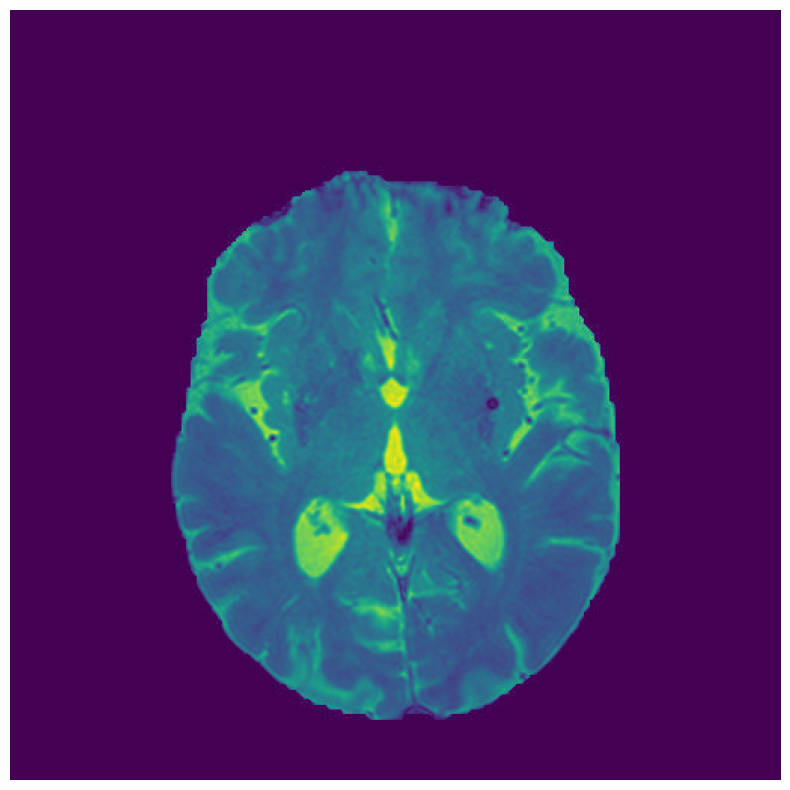

In [4]:
src = "D:/dachuang/archive/test1/images/102.jpg"
i=detection_model.predict(source= src, conf=0.5, save=True, line_width=2, show_labels=True)

im = plt.imread(src)
plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(im)


# 训练YOLO

我们的目标是通过在包含专门针对CMB图像的数据集上训练YOLO来增强它的检测能力。我们期望提高检测准确性，使YOLO与我们的目标一致

创建基本函数
为了对图像进行有效的YOLO训练，我们的首要任务是建立关键函数。

In [6]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])
            
            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

def imagen_anotada(ruta_archivo, ruta_imagenes, numero_imagen,numero_imagen2):
    ruta_imagen = ruta_imagenes + numero_imagen
    
    with open(ruta_archivo, 'r') as f:
        archivo= f.read()
        datos_json = json.loads(archivo)

    elemento_seleccionado = datos_json[numero_imagen2]    
    if elemento_seleccionado['shapes'][0]:
        region = elemento_seleccionado['shapes'][0]
        nombre_forma = region['label']

        imagen = Image.open(ruta_imagen)
        fig, ax = plt.subplots()
        ax.imshow(imagen)

        if nombre_forma == 'cmb1':
            print(region['points'][0])
            coordenadas_x = [point[0] for point in region['points']]
            coordenadas_y = [point[1] for point in region['points']]
            poligono = Polygon(np.column_stack((coordenadas_x, coordenadas_y)), edgecolor='r', linewidth=2, facecolor='none')
            ax.add_patch(poligono)

        ax.set_title(f'Anotación en {numero_imagen}')
        plt.axis('off') 
        plt.show()
    
    else:
        print("No tiene anotación, pero la imagen es: ")
        mostrar_imagen(ruta_imagen)

def borrar_carpeta(path_carpeta):
    try:
        # Utiliza shutil.rmtree para borrar la carpeta y su contenido de forma recursiva
        shutil.rmtree(path_carpeta)
        print(f'Carpeta {path_carpeta} borrada exitosamente.')
    except Exception as e:
        print(f'Error al borrar la carpeta: {e}')

[296.68441064638785, 325.2015209125475]


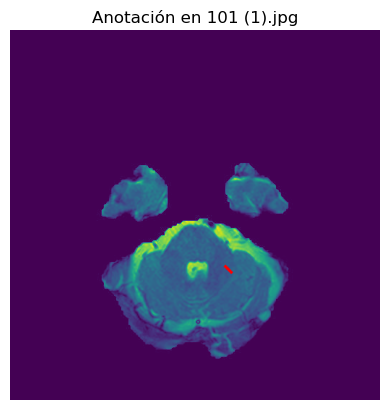

[344.90238611713664, 224.94577006507592]


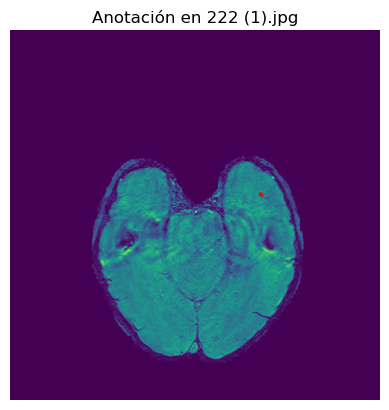

[80.85171102661599, 119.63498098859316]


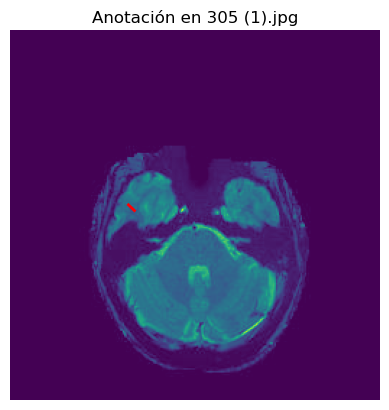

<Figure size 640x480 with 0 Axes>

In [8]:
ruta_archivo = "D:/dachuang/archive/annotations.json"
ruta_imagenes = "D:/dachuang/archive/train1/images/"
path = "D:/dachuang/"



numeros_imagenes = ["101 (1).jpg", "222 (1).jpg", "305 (1).jpg"]
numeros_imagenes2 = ["101 (1).jpg", "222 (1).jpg", "305 (1).jpg"]

for i in range(0,3):
    numero_imagen=numeros_imagenes[i]
    numero_imagen2=numeros_imagenes2[i]
    imagen_anotada(ruta_archivo, ruta_imagenes, numero_imagen,numero_imagen2)

plt.tight_layout()
plt.show()


准备注释数据
在这个子步骤中，我们的重点是为训练过程制作边界框注释。
必要的信息存在于.json文件中，但关键是要注意shapes。

In [10]:
def create_bbox_json(input_json, output_json):
    with open(input_json, 'r') as f:
        data = json.load(f)
    new_data = []

    for image_info in data:
        new_image_info = {'filename': image_info, 'boxes': []}
        print(new_image_info)
        
        elemento = data[image_info]
        
        imagen = "D:/dachuang/archive/yes/" +  image_info
        print(imagen)
        
        img = cv2.imread(imagen)
        print(img)
        
        height, width, channels = img.shape
        
        for region in elemento['shapes']:
            box = {}
            shape_type = region['shape_type']
            points = region['points']
            description = region['description']
            box['class'] = '1'
            
            if 'points' in region:
                # Obtener bounding box a partir de los puntos del polígono
                x_coords = [point[0] for point in region['points']]
                y_coords = [point[1] for point in region['points']]
                box['center_x'] = (min(x_coords) + max(x_coords)) / 2
                box['center_y'] = (min(y_coords) + max(y_coords)) / 2
                box['width'] = max(x_coords) - min(x_coords)
                box['height'] = max(y_coords) - min(y_coords)
            
            # Normalizar las coordenadas
            box['center_x'] = round(box['center_x'] / width, 6)
            box['center_y'] = round(box['center_y'] / height, 6)
            box['width'] = round(box['width'] / width, 6)
            box['height'] = round(box['height'] / height, 6)
            
            new_image_info['boxes'].append(box)
            
        new_data.append(new_image_info)
        
        # Crear el archivo de texto para cada imagen
        txt_filename = os.path.join("D:/dachuang/archive/working", os.path.splitext(image_info)[0] + '.txt')
        with open(txt_filename, 'w') as txt_file:
            for box in new_image_info['boxes']:
                txt_file.write(f"{box['class']} {box['center_x']} {box['center_y']} {box['width']} {box['height']}\n")

    with open(output_json, 'w') as f:
        json.dump(new_data, f, indent=2)

create_bbox_json("D:/dachuang/archive/annotations.json", "D:/dachuang/archive/bbox.json")

{'filename': '102.jpg', 'boxes': []}
D:/dachuang/archive/yes/102.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '106.jpg', 'boxes': []}
D:/dachuang/archive/yes/106.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '108 (1).jpg', 'boxes

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '221 (12).jpg', 'boxes': []}
D:/dachuang/archive/yes/221 (12).jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '221 (13).jpg', 'boxes': []}
D:/dachuang/archive/yes/221 (13).jpg
[[[0 0 0]
  [0

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '228 (5).jpg', 'boxes': []}
D:/dachuang/archive/yes/228 (5).jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '228 (6).jpg', 'boxes': []}
D:/dachuang/archive/yes/228 (6).jpg
[[[0 0 0]
  [0 0 0

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '314.jpg', 'boxes': []}
D:/dachuang/archive/yes/314.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
{'filename': '315.jpg', 'boxes': []}
D:/dachuang/archive/yes/315.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ..

验证
为了确保准备工作的准确性，让我们打印图像的注释。
这一步允许我们直观地检查边界框注释，并确认我们的方法有效地捕获了边界框的信息

In [11]:
a = "D:/dachuang/archive/working/306.txt"

with open(a, 'r') as b:
    contenido = b.read()
    # Ahora 'contenido' contiene el contenido del archivo y puedes realizar operaciones con él
    print(contenido)

1 0.49082 0.529883 0.012891 0.012109



定义图像绘图函数
为了简化视觉检查过程，我们将创建专门用于绘制图像及其相应注释的函数。
这些函数将有助于从视觉上验证边界框注释的准确性。

In [12]:
def convert(size,x,y,w,h):
    box = np.zeros(4)
    dw = 1./size[0]
    dh = 1./size[1]
    x = x/dw
    w = w/dw
    y = y/dh
    h = h/dh
    box[0] = x-(w/2.0)
    box[1] = x+(w/2.0)
    box[2] = y-(h/2.0)
    box[3] = y+(h/2.0)

    return (box)

def plot_annotations(img, filename):
    with open(annotations_path+filename, 'r') as f:
        for line in f:
            value = line.split()
            cls = int(value[0])
            x = float(value[1])
            y = float(value[2])
            w = float(value[3])
            h = float(value[4])
            
            img_h, img_w = img.shape[:2]
            bb = convert((img_w, img_h), x,y,w,h)
            cv2.rectangle(img, (int(round(bb[0])),int(round(bb[2]))),(int(round(bb[1])),int(round(bb[3]))),(255,0,0),2)
            plt.axis('off')
            plt.imshow(img)

显示带有注释的随机图像
为了进行快速的视觉评估，让我们展示一些图像及其注释。
这种随机抽样将提供数据集的快照，允许我们确认我们的边界框注释准确地与图像中存在的各种形状对齐。

156
309.jpg
207 (10).jpg
222 (1).jpg
221 (6).jpg
221 (34).jpg
217 (4).jpg
221 (2).jpg
223 (3).jpg
234 (5).jpg
207 (6).jpg


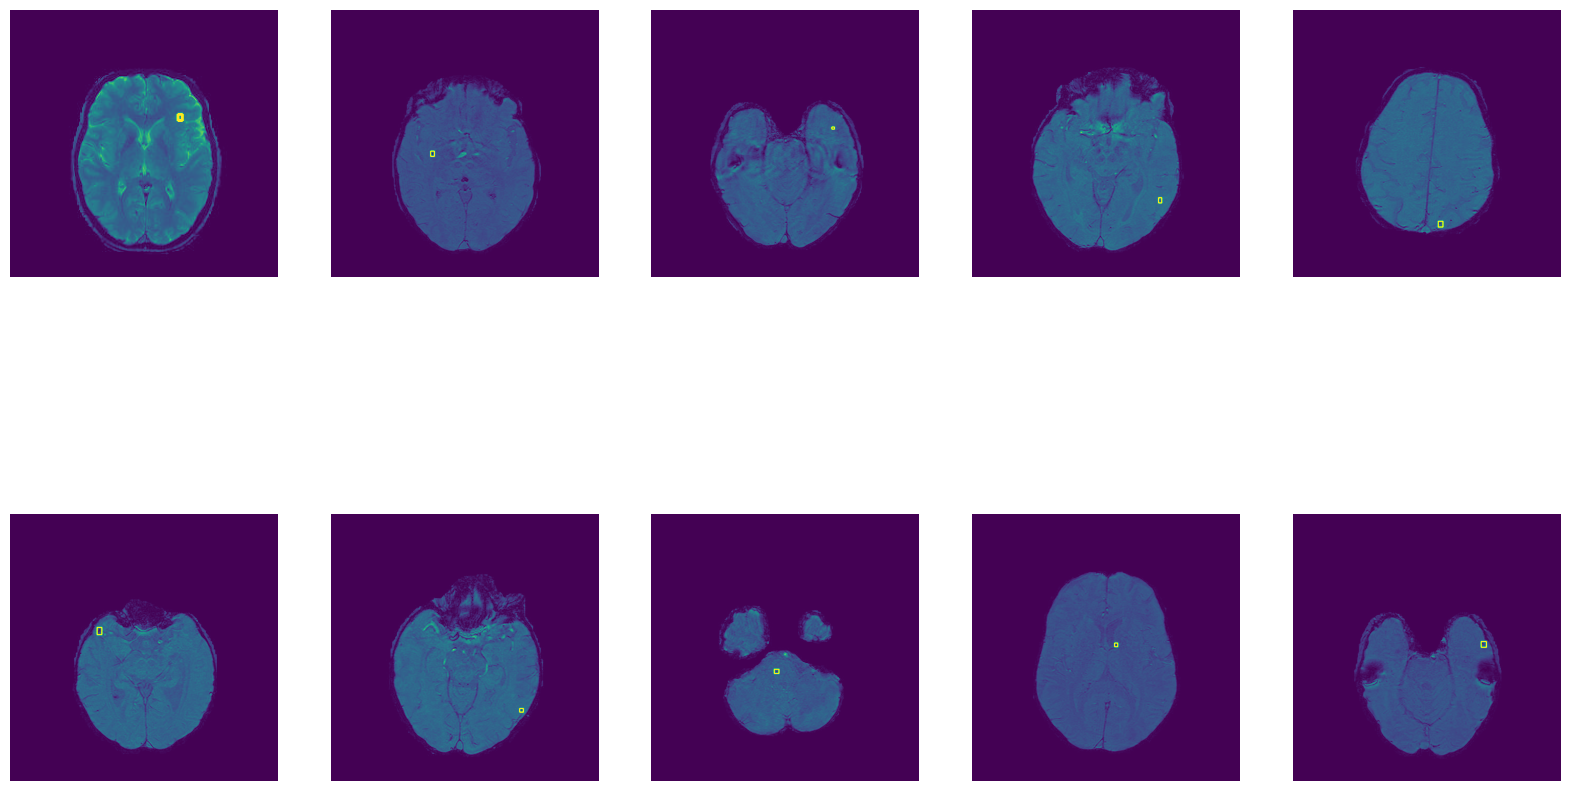

In [13]:
import os
import random
import matplotlib.pyplot as plt
import cv2
import numpy as np

images_path = "D:/dachuang/archive/train1/images/"
annotations_path = "D:/dachuang/archive/working/"
plt.figure(figsize=(20,12))
ls = os.listdir(images_path)

print(len(ls))

c = 1
for i in random.sample(ls, 10):
    print(i)
    img = plt.imread(images_path+i)
    i = i.rstrip('.jpg') + '.txt'
    plt.subplot(2,5, c)
    plot_annotations(img, i)
    c+=1

显示带有注释的选定图像
为了进行更有针对性的检查，让我们展示一个特定的图像及其相应的注释

In [14]:
 def mostrar_imagen(num):
    i = str(num) + ".jpg"
    img = plt.imread(images_path+i)
    note = str(num)+ ".txt"
    i = i.rstrip('.jpg') + '.txt'

    plot_annotations(img, i)
    


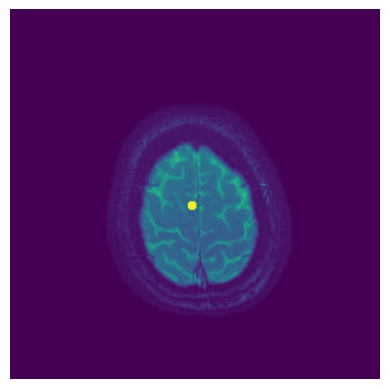

In [16]:
annotations_path = "D:/dachuang/archive/working/"
mostrar_imagen(306)

训练模型
准备好数据集和注释后，是时候开始训练我们的YOLO模型了。
这一步包括将我们的整理的数据集输入模型，使其能够学习并微调其参数以完成检测任务

模型训练
现在我们的数据集被适当地分割了，我们可以深入到的核心——训练YOLO模型。
这一步包括将模型应用我们的训练数据集，允许它学习和调整其参数以有效地检测。
当模型通过训练数据迭代时，它会改进它的理解，使我们更接近训练有素的检测模型。

In [ ]:
text = """
train: D:/dachuang/archive/train1
val: D:/dachuang/archive/test1
 


# Ultralytics YOLO, AGPL-3.0 license
# YOLOv8 object detection model with P3-P5 outputs. For Usage examples see https://docs.ultralytics.com/tasks/detect

# number of classes
nc: 2
scales: # model compound scaling constants, i.e. 'model=yolov8n.yaml' will call yolov8.yaml with scale 'n'
  # [depth, width, max_channels]
  n: [0.33, 0.25, 1024]  # YOLOv8n summary: 225 layers,  3157200 parameters,  3157184 gradients,   8.9 GFLOPs
  s: [0.33, 0.50, 1024]  # YOLOv8s summary: 225 layers, 11166560 parameters, 11166544 gradients,  28.8 GFLOPs
  m: [0.67, 0.75, 768]   # YOLOv8m summary: 295 layers, 25902640 parameters, 25902624 gradients,  79.3 GFLOPs
  l: [1.00, 1.00, 512]   # YOLOv8l summary: 365 layers, 43691520 parameters, 43691504 gradients, 165.7 GFLOPs
  x: [1.00, 1.25, 512]   # YOLOv8x summary: 365 layers, 68229648 parameters, 68229632 gradients, 258.5 GFLOPs


# class names
names: ['not' , cmb']


# YOLOv8.0n backbone
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]]  # 1-P2/4
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]]  # 3-P3/8
  - [-1, 6, C2f, [256, True]]
  - [-1, 1,GSConv, [512, 3, 2]]  # 5-P4/16
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]  # 7-P5/32
  - [-1, 3, C2f, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]]  # 9

# YOLOv8.0n head
head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
  - [-1, 3, VoVGSCSP, [512]]  # 12

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
  - [-1, 3, VoVGSCSP, [256]]  # 15 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]  # cat head P4
  - [-1, 3, VoVGSCSP, [512]]  # 18 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P5
  - [-1, 3, VoVGSCSP, [1024]]  # 21 (P5/32-large)

  - [[15, 18, 21], 1, Detect, [nc]]  # Detect(P3, P4, P5)


"""
with open("D:/dachuang/data.yaml", 'w') as file:
    file.write(text)

In [ ]:
import torch.nn as nn
import ultralytics.nn

from ultralytics.nn.SwinTransformer import VoVGSCSP, VoVGSCSPC, GSConv
from ultralytics.nn.modules import (AIFI, C1, C2, C3, C3TR, SPP, SPPF, Bottleneck, BottleneckCSP, C2f, C3Ghost, C3x,
                                    Classify, Concat, Conv, Conv2, ConvTranspose, Detect, DWConv, DWConvTranspose2d,
                                    Focus, GhostBottleneck, GhostConv, HGBlock, HGStem, Pose, RepC3, RepConv,
                                    RTDETRDecoder, Segment)
from ultralytics import YOLO

In [74]:
model = YOLO("yolov8m.pt")
model.train(data='data.yaml', epochs=50, workers=0)

Ultralytics YOLOv8.0.145  Python-3.7.16 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=tor

       7/50      7.15G      2.748      2.887      0.984         16        640: 100%|██████████| 10/10 [01:59<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<0
                   all         53         70    0.00208     0.0286   0.000652   0.000328

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/50      7.14G      3.037      2.686      1.005         22        640: 100%|██████████| 10/10 [02:19<00:00, 13.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:09<?


KeyboardInterrupt: 

In [82]:
import torch
# model = YOLO("yolov8m.pt")
# model.train(data='data.yaml', epochs=50, workers=0)
torch.load("D:/dachuang/runs/detect/train9/weights/best.pt")
#model.load("D:/dachuang/runs/detect/train9/weights/best.pt")

{'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C2f(
       (cv1): Conv(
         (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (cv2): Conv(
         (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, trac

可视化训练进度
图表显示关键信息，如损失趋势和准确性，
将提供一个清晰的概述，我们的YOLO模型是如何适应和学习训练数据。

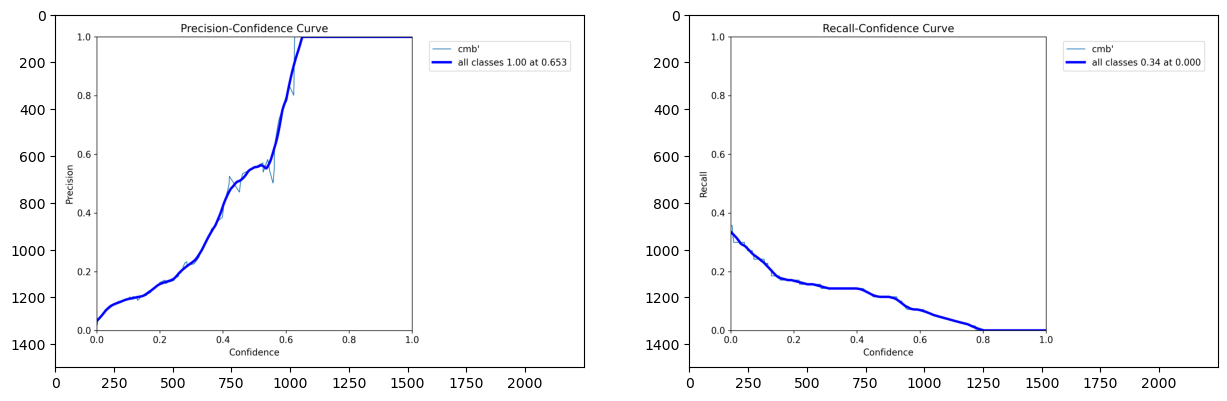

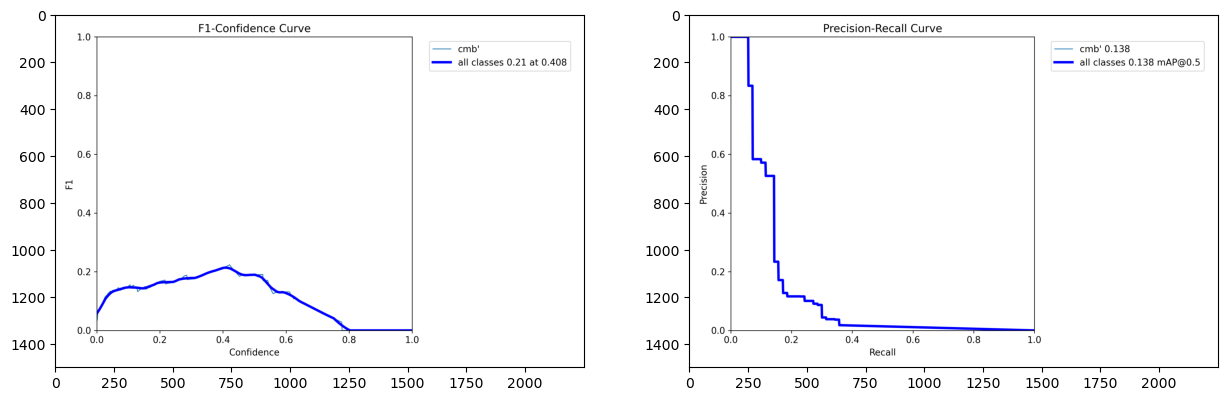

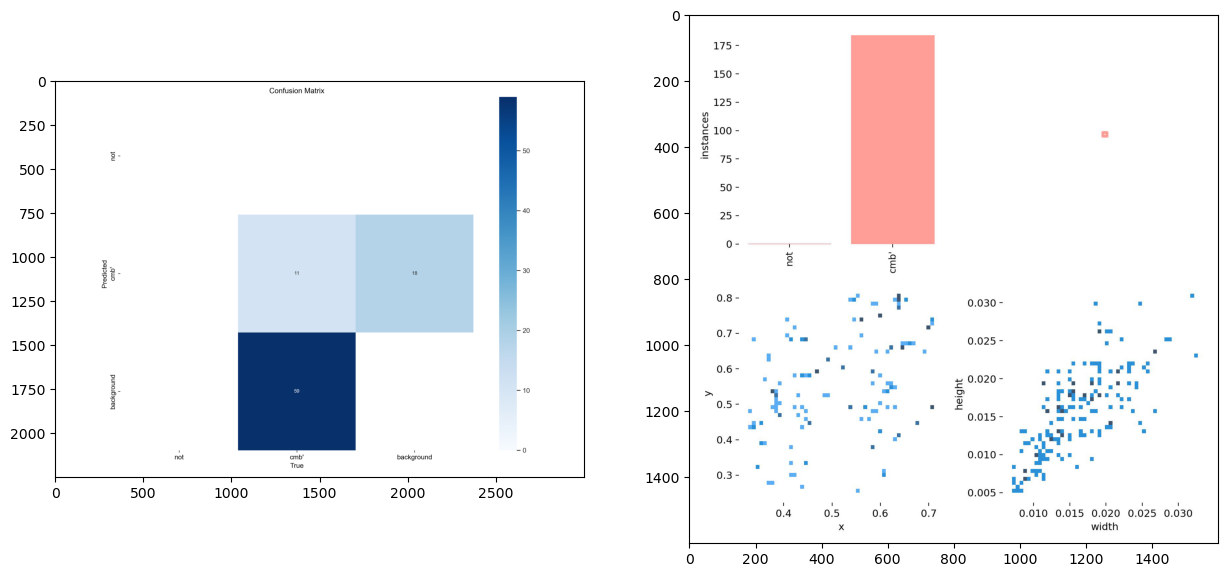

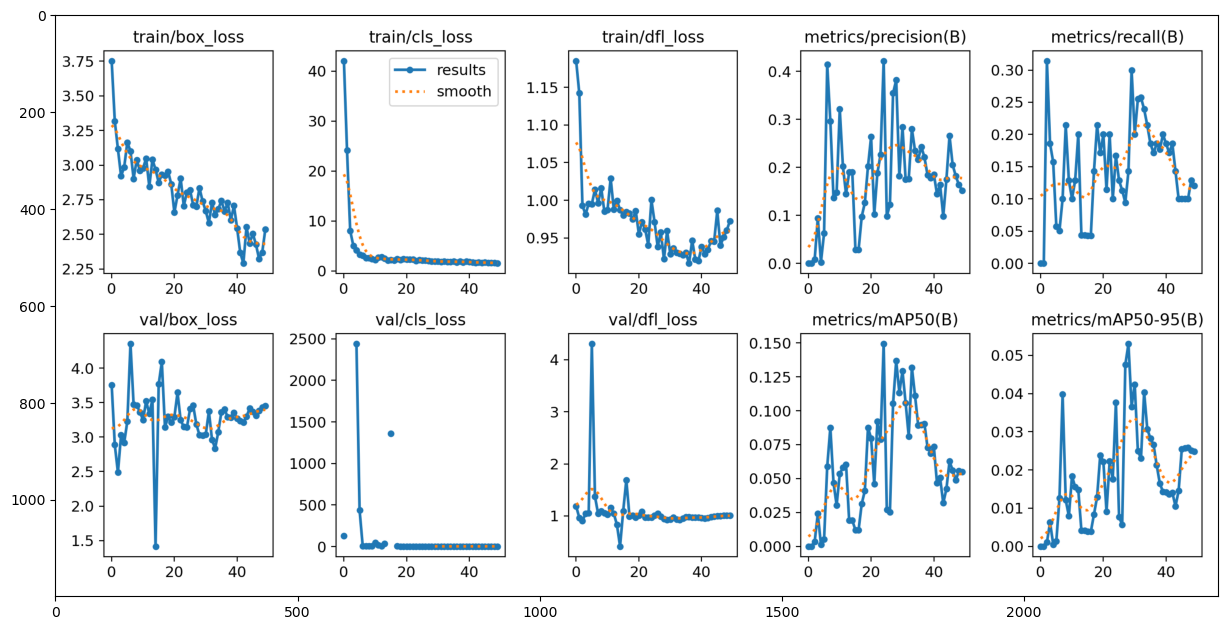

In [27]:
model_path = 'runs/detect/train9/'

def plot(ls, size):
    c=1
    plt.figure(figsize=(15,10))
    for im in ls:
        plt.subplot(size[0],size[1],c)
        im = plt.imread(model_path+im)
        plt.imshow(im)
        c+=1
    plt.show()

plot(['P_curve.png','R_curve.png'], (1,2))
plot(['F1_curve.png','PR_curve.png'], (1,2))
plot(['confusion_matrix.png','labels.jpg'], (1,2))
plot(['results.png'],(1,1))

In [18]:
from ultralytics import YOLO

import random
import os


# 加载训练好的模型权重
model = YOLO("D:/dachuang/runs/detect/train9/weights/best.pt")

# 指定待预测的图像路径
images_path = "D:/dachuang/dataset/jpg/"
img = random.sample(os.listdir(images_path), 1)
img = img[0]
print(img)

i=model.predict(source=images_path+img, save=True, line_width=1)

from PIL import Image
result = i[0]

print("\n")

box_ = result.boxes

for box in box_:
    class_id = result.names[box.cls[0].item()]
    cords = box.xyxy[0].tolist()
    cords = [round(x) for x in cords]
    conf = round(box.conf[0].item(), 2)
    print("Object type:", class_id)
    print("Coordinates:", cords)
    print("Probability:", conf)
    print("---")
    



slice_26.jpg



image 1/1 D:\dachuang\dataset\jpg\slice_26.jpg: 640x640 (no detections), 85.7ms
Speed: 4.8ms preprocess, 85.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


In [27]:
from ultralytics import YOLO
import os

# 加载训练好的模型权重
model = YOLO("D:/dachuang/runs/detect/train9/weights/best.pt")

# 指定待预测的图像路径
images_path = "D:/dachuang/dataset/jpg/"

# 获取文件夹下所有图像文件
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

for img in image_files:
    print("Processing image:", img)
    predictions = model.predict(source=images_path + img, save=True, line_width=1)
    
    for result in predictions:
        boxes = result.boxes

        for box in boxes:
            class_id = result.names[box.cls[0].item()]
            cords = box.xyxy[0].tolist()
            cords = [round(x) for x in cords]
            conf = round(box.conf[0].item(), 2)
            print("Object type:", class_id)
            print("Coordinates:", cords)
            print("Probability:", conf)
            print("---")


Processing image: slice_0.jpg



image 1/1 D:\dachuang\dataset\jpg\slice_0.jpg: 640x640 (no detections), 167.0ms
Speed: 5.1ms preprocess, 167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_1.jpg: 640x640 (no detections), 85.6ms
Speed: 3.5ms preprocess, 85.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_10.jpg: 640x640 (no detections), 85.6ms


Processing image: slice_1.jpg
Processing image: slice_10.jpg


Speed: 3.9ms preprocess, 85.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_100.jpg: 640x640 1 cmb', 84.3ms
Speed: 4.5ms preprocess, 84.3ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_100.jpg
Object type: cmb'
Coordinates: [347, 135, 353, 141]
Probability: 0.3
---
Processing image: slice_101.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_101.jpg: 640x640 1 cmb', 86.5ms
Speed: 4.1ms preprocess, 86.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_102.jpg: 640x640 1 cmb', 85.5ms
Speed: 4.0ms preprocess, 85.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Object type: cmb'
Coordinates: [347, 133, 354, 140]
Probability: 0.28
---
Processing image: slice_102.jpg
Object type: cmb'
Coordinates: [347, 132, 354, 139]
Probability: 0.26
---
Processing image: slice_103.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_103.jpg: 640x640 (no detections), 86.0ms
Speed: 3.5ms preprocess, 86.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_104.jpg: 640x640 (no detections), 84.1ms
Speed: 4.6ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_105.jpg: 640x640 (no detections), 85.3ms


Processing image: slice_104.jpg
Processing image: slice_105.jpg


Speed: 3.5ms preprocess, 85.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_106.jpg: 640x640 (no detections), 84.9ms
Speed: 4.0ms preprocess, 84.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_106.jpg
Processing image: slice_107.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_107.jpg: 640x640 (no detections), 85.1ms
Speed: 4.0ms preprocess, 85.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_108.jpg: 640x640 (no detections), 85.7ms
Speed: 4.1ms preprocess, 85.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_108.jpg
Processing image: slice_109.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_109.jpg: 640x640 1 cmb', 85.9ms
Speed: 3.9ms preprocess, 85.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_11.jpg: 640x640 (no detections), 84.4ms
Speed: 4.0ms preprocess, 84.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_110.jpg: 640x640 (no detections), 84.9ms


Object type: cmb'
Coordinates: [347, 158, 354, 165]
Probability: 0.3
---
Processing image: slice_11.jpg
Processing image: slice_110.jpg


Speed: 4.6ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_111.jpg: 640x640 (no detections), 84.1ms
Speed: 4.0ms preprocess, 84.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_112.jpg: 640x640 (no detections), 85.7ms


Processing image: slice_111.jpg
Processing image: slice_112.jpg


Speed: 5.0ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_113.jpg: 640x640 1 cmb', 84.1ms
Speed: 4.0ms preprocess, 84.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_114.jpg: 640x640 (no detections), 86.5ms


Processing image: slice_113.jpg
Object type: cmb'
Coordinates: [176, 120, 183, 128]
Probability: 0.29
---
Processing image: slice_114.jpg


Speed: 2.5ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_115.jpg: 640x640 (no detections), 85.2ms
Speed: 4.6ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_116.jpg: 640x640 (no detections), 84.8ms


Processing image: slice_115.jpg
Processing image: slice_116.jpg


Speed: 4.5ms preprocess, 84.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_117.jpg: 640x640 (no detections), 84.4ms
Speed: 4.0ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_118.jpg: 640x640 (no detections), 84.7ms


Processing image: slice_117.jpg
Processing image: slice_118.jpg


Speed: 4.0ms preprocess, 84.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_119.jpg: 640x640 (no detections), 84.7ms
Speed: 4.0ms preprocess, 84.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_119.jpg
Processing image: slice_12.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_12.jpg: 640x640 (no detections), 85.8ms
Speed: 4.6ms preprocess, 85.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_120.jpg: 640x640 (no detections), 86.8ms
Speed: 3.5ms preprocess, 86.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_121.jpg: 640x640 (no detections), 85.8ms


Processing image: slice_120.jpg
Processing image: slice_121.jpg


Speed: 3.7ms preprocess, 85.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_122.jpg: 640x640 (no detections), 84.2ms
Speed: 4.1ms preprocess, 84.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_123.jpg: 640x640 (no detections), 84.0ms


Processing image: slice_122.jpg
Processing image: slice_123.jpg


Speed: 5.0ms preprocess, 84.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_124.jpg: 640x640 (no detections), 85.5ms
Speed: 4.9ms preprocess, 85.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_125.jpg: 640x640 (no detections), 86.5ms


Processing image: slice_124.jpg
Processing image: slice_125.jpg


Speed: 4.6ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_126.jpg: 640x640 (no detections), 85.4ms
Speed: 4.2ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_127.jpg: 640x640 (no detections), 84.6ms


Processing image: slice_126.jpg
Processing image: slice_127.jpg


Speed: 3.0ms preprocess, 84.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_128.jpg: 640x640 (no detections), 85.9ms
Speed: 5.3ms preprocess, 85.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_129.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_128.jpg
Processing image: slice_129.jpg


Speed: 4.5ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_13.jpg: 640x640 (no detections), 86.4ms
Speed: 3.5ms preprocess, 86.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_13.jpg
Processing image: slice_130.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_130.jpg: 640x640 (no detections), 85.2ms
Speed: 4.1ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_131.jpg: 640x640 (no detections), 84.2ms
Speed: 3.9ms preprocess, 84.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_131.jpg
Processing image: slice_132.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_132.jpg: 640x640 (no detections), 84.5ms
Speed: 5.0ms preprocess, 84.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_133.jpg: 640x640 (no detections), 85.4ms
Speed: 5.3ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_134.jpg: 640x640 (no detections), 85.5ms


Processing image: slice_133.jpg
Processing image: slice_134.jpg


Speed: 4.0ms preprocess, 85.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_135.jpg: 640x640 (no detections), 85.5ms
Speed: 4.0ms preprocess, 85.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_136.jpg: 640x640 (no detections), 85.5ms


Processing image: slice_135.jpg
Processing image: slice_136.jpg


Speed: 4.5ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_137.jpg: 640x640 (no detections), 84.7ms
Speed: 5.0ms preprocess, 84.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_138.jpg: 640x640 (no detections), 85.9ms


Processing image: slice_137.jpg
Processing image: slice_138.jpg


Speed: 3.5ms preprocess, 85.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_139.jpg: 640x640 (no detections), 85.4ms
Speed: 3.0ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_14.jpg: 640x640 (no detections), 85.1ms


Processing image: slice_139.jpg
Processing image: slice_14.jpg


Speed: 3.5ms preprocess, 85.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_140.jpg: 640x640 (no detections), 85.7ms
Speed: 3.0ms preprocess, 85.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_141.jpg: 640x640 (no detections), 83.8ms


Processing image: slice_140.jpg
Processing image: slice_141.jpg


Speed: 4.1ms preprocess, 83.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_142.jpg: 640x640 (no detections), 85.1ms
Speed: 5.3ms preprocess, 85.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_142.jpg
Processing image: slice_143.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_143.jpg: 640x640 (no detections), 85.6ms
Speed: 3.6ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_144.jpg: 640x640 (no detections), 85.3ms
Speed: 2.5ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_145.jpg: 640x640 (no detections), 84.3ms


Processing image: slice_144.jpg
Processing image: slice_145.jpg


Speed: 4.6ms preprocess, 84.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_146.jpg: 640x640 (no detections), 86.0ms
Speed: 4.0ms preprocess, 86.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_146.jpg
Processing image: slice_147.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_147.jpg: 640x640 (no detections), 85.3ms
Speed: 5.1ms preprocess, 85.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_148.jpg: 640x640 (no detections), 86.0ms
Speed: 3.5ms preprocess, 86.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_149.jpg: 640x640 (no detections), 84.1ms


Processing image: slice_148.jpg
Processing image: slice_149.jpg


Speed: 4.6ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_15.jpg: 640x640 (no detections), 84.5ms
Speed: 3.6ms preprocess, 84.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_16.jpg: 640x640 (no detections), 86.3ms


Processing image: slice_15.jpg
Processing image: slice_16.jpg


Speed: 2.0ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_17.jpg: 640x640 (no detections), 86.3ms
Speed: 4.0ms preprocess, 86.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_17.jpg
Processing image: slice_18.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_18.jpg: 640x640 (no detections), 85.3ms
Speed: 4.5ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_19.jpg: 640x640 (no detections), 84.6ms
Speed: 2.5ms preprocess, 84.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_2.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_19.jpg
Processing image: slice_2.jpg


Speed: 3.1ms preprocess, 85.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_20.jpg: 640x640 (no detections), 85.7ms
Speed: 5.1ms preprocess, 85.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_20.jpg
Processing image: slice_21.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_21.jpg: 640x640 (no detections), 86.4ms
Speed: 4.7ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_22.jpg: 640x640 (no detections), 85.3ms
Speed: 6.3ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_22.jpg
Processing image: slice_23.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_23.jpg: 640x640 (no detections), 84.1ms
Speed: 5.6ms preprocess, 84.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_24.jpg: 640x640 (no detections), 85.8ms
Speed: 5.5ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_25.jpg: 640x640 (no detections), 84.9ms


Processing image: slice_24.jpg
Processing image: slice_25.jpg


Speed: 4.8ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_26.jpg: 640x640 (no detections), 86.6ms
Speed: 6.4ms preprocess, 86.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_26.jpg
Processing image: slice_27.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_27.jpg: 640x640 (no detections), 84.9ms
Speed: 6.0ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_28.jpg: 640x640 (no detections), 85.2ms
Speed: 5.0ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_28.jpg
Processing image: slice_29.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_29.jpg: 640x640 (no detections), 86.3ms
Speed: 4.0ms preprocess, 86.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_3.jpg: 640x640 (no detections), 86.5ms
Speed: 5.6ms preprocess, 86.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_30.jpg: 640x640 (no detections), 87.2ms


Processing image: slice_3.jpg
Processing image: slice_30.jpg


Speed: 2.5ms preprocess, 87.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_31.jpg: 640x640 (no detections), 85.7ms
Speed: 4.6ms preprocess, 85.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_32.jpg: 640x640 (no detections), 84.3ms


Processing image: slice_31.jpg
Processing image: slice_32.jpg


Speed: 4.6ms preprocess, 84.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_33.jpg: 640x640 (no detections), 85.4ms
Speed: 4.6ms preprocess, 85.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_33.jpg
Processing image: slice_34.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_34.jpg: 640x640 (no detections), 84.7ms
Speed: 4.1ms preprocess, 84.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_35.jpg: 640x640 (no detections), 85.2ms
Speed: 3.1ms preprocess, 85.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_35.jpg
Processing image: slice_36.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_36.jpg: 640x640 (no detections), 85.6ms
Speed: 4.1ms preprocess, 85.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_37.jpg: 640x640 (no detections), 86.2ms
Speed: 3.5ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_38.jpg: 640x640 (no detections), 84.0ms


Processing image: slice_37.jpg
Processing image: slice_38.jpg


Speed: 6.1ms preprocess, 84.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_39.jpg: 640x640 (no detections), 85.0ms
Speed: 4.7ms preprocess, 85.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_39.jpg
Processing image: slice_4.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_4.jpg: 640x640 (no detections), 86.8ms
Speed: 4.7ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_40.jpg: 640x640 (no detections), 85.2ms
Speed: 4.7ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_41.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_40.jpg
Processing image: slice_41.jpg


Speed: 4.1ms preprocess, 85.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_42.jpg: 640x640 (no detections), 85.4ms
Speed: 5.6ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_43.jpg: 640x640 (no detections), 84.9ms


Processing image: slice_42.jpg
Processing image: slice_43.jpg


Speed: 5.0ms preprocess, 84.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_44.jpg: 640x640 (no detections), 84.7ms
Speed: 5.6ms preprocess, 84.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_44.jpg
Processing image: slice_45.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_45.jpg: 640x640 (no detections), 83.7ms
Speed: 5.1ms preprocess, 83.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_46.jpg: 640x640 (no detections), 85.3ms
Speed: 5.1ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_47.jpg: 640x640 (no detections), 86.1ms


Processing image: slice_46.jpg
Processing image: slice_47.jpg


Speed: 4.1ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_48.jpg: 640x640 (no detections), 85.8ms
Speed: 3.5ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_48.jpg
Processing image: slice_49.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_49.jpg: 640x640 (no detections), 86.8ms
Speed: 4.5ms preprocess, 86.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_5.jpg: 640x640 (no detections), 84.5ms
Speed: 4.1ms preprocess, 84.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_5.jpg
Processing image: slice_50.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_50.jpg: 640x640 (no detections), 85.0ms
Speed: 10.6ms preprocess, 85.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_51.jpg: 640x640 (no detections), 85.4ms
Speed: 7.6ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_51.jpg
Processing image: slice_52.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_52.jpg: 640x640 (no detections), 85.1ms
Speed: 9.7ms preprocess, 85.1ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_53.jpg: 640x640 (no detections), 86.1ms
Speed: 5.5ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_54.jpg: 640x640 (no detections), 84.4ms


Processing image: slice_53.jpg
Processing image: slice_54.jpg


Speed: 4.2ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_55.jpg: 640x640 (no detections), 86.1ms
Speed: 4.6ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_55.jpg
Processing image: slice_56.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_56.jpg: 640x640 (no detections), 86.8ms
Speed: 4.8ms preprocess, 86.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_57.jpg: 640x640 (no detections), 85.1ms
Speed: 5.1ms preprocess, 85.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_58.jpg: 640x640 (no detections), 84.5ms


Processing image: slice_57.jpg
Processing image: slice_58.jpg


Speed: 5.0ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_59.jpg: 640x640 (no detections), 85.6ms
Speed: 4.5ms preprocess, 85.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_59.jpg
Processing image: slice_6.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_6.jpg: 640x640 (no detections), 85.5ms
Speed: 6.0ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_60.jpg: 640x640 (no detections), 84.7ms
Speed: 5.1ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_60.jpg
Processing image: slice_61.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_61.jpg: 640x640 (no detections), 85.8ms
Speed: 2.5ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_62.jpg: 640x640 (no detections), 85.0ms
Speed: 4.6ms preprocess, 85.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_63.jpg: 640x640 (no detections), 85.1ms


Processing image: slice_62.jpg
Processing image: slice_63.jpg


Speed: 5.9ms preprocess, 85.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_64.jpg: 640x640 (no detections), 86.2ms
Speed: 4.6ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_64.jpg
Processing image: slice_65.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_65.jpg: 640x640 1 cmb', 84.1ms
Speed: 4.6ms preprocess, 84.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_66.jpg: 640x640 1 cmb', 86.2ms
Speed: 4.1ms preprocess, 86.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_67.jpg: 640x640 (no detections), 87.2ms


Object type: cmb'
Coordinates: [251, 183, 259, 191]
Probability: 0.25
---
Processing image: slice_66.jpg
Object type: cmb'
Coordinates: [251, 184, 259, 191]
Probability: 0.25
---
Processing image: slice_67.jpg


Speed: 3.2ms preprocess, 87.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_68.jpg: 640x640 (no detections), 86.2ms
Speed: 3.6ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_68.jpg
Processing image: slice_69.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_69.jpg: 640x640 (no detections), 84.8ms
Speed: 4.5ms preprocess, 84.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_7.jpg: 640x640 (no detections), 84.9ms
Speed: 4.5ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_70.jpg: 640x640 (no detections), 85.9ms


Processing image: slice_7.jpg
Processing image: slice_70.jpg


Speed: 5.1ms preprocess, 85.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_71.jpg: 640x640 (no detections), 85.3ms
Speed: 4.5ms preprocess, 85.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_72.jpg: 640x640 (no detections), 86.1ms


Processing image: slice_71.jpg
Processing image: slice_72.jpg


Speed: 4.6ms preprocess, 86.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_73.jpg: 640x640 (no detections), 84.9ms
Speed: 4.1ms preprocess, 84.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_74.jpg: 640x640 (no detections), 85.2ms


Processing image: slice_73.jpg
Processing image: slice_74.jpg


Speed: 4.1ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_75.jpg: 640x640 (no detections), 85.8ms
Speed: 4.8ms preprocess, 85.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_76.jpg: 640x640 (no detections), 85.2ms


Processing image: slice_75.jpg
Processing image: slice_76.jpg


Speed: 4.6ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_77.jpg: 640x640 (no detections), 85.6ms
Speed: 4.7ms preprocess, 85.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_77.jpg
Processing image: slice_78.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_78.jpg: 640x640 (no detections), 85.4ms
Speed: 4.9ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_79.jpg: 640x640 (no detections), 87.0ms
Speed: 3.6ms preprocess, 87.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_8.jpg: 640x640 (no detections), 85.3ms


Processing image: slice_79.jpg
Processing image: slice_8.jpg


Speed: 4.1ms preprocess, 85.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_80.jpg: 640x640 (no detections), 84.9ms
Speed: 5.1ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_81.jpg: 640x640 (no detections), 85.3ms


Processing image: slice_80.jpg
Processing image: slice_81.jpg


Speed: 3.4ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_82.jpg: 640x640 (no detections), 85.2ms
Speed: 4.1ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_83.jpg: 640x640 (no detections), 86.3ms


Processing image: slice_82.jpg
Processing image: slice_83.jpg


Speed: 4.1ms preprocess, 86.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_84.jpg: 640x640 1 cmb', 86.4ms
Speed: 5.1ms preprocess, 86.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_84.jpg
Object type: cmb'
Coordinates: [216, 133, 222, 140]
Probability: 0.26
---
Processing image: slice_85.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_85.jpg: 640x640 (no detections), 86.2ms
Speed: 3.5ms preprocess, 86.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_86.jpg: 640x640 (no detections), 85.0ms
Speed: 4.8ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_87.jpg: 640x640 (no detections), 85.8ms


Processing image: slice_86.jpg
Processing image: slice_87.jpg


Speed: 4.7ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_88.jpg: 640x640 (no detections), 85.8ms
Speed: 4.5ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_88.jpg
Processing image: slice_89.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_89.jpg: 640x640 (no detections), 85.9ms
Speed: 5.1ms preprocess, 85.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_9.jpg: 640x640 (no detections), 85.6ms
Speed: 5.5ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_9.jpg
Processing image: slice_90.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_90.jpg: 640x640 (no detections), 85.2ms
Speed: 5.4ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_91.jpg: 640x640 (no detections), 85.1ms
Speed: 5.1ms preprocess, 85.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_92.jpg: 640x640 (no detections), 86.2ms


Processing image: slice_91.jpg
Processing image: slice_92.jpg


Speed: 4.6ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_93.jpg: 640x640 (no detections), 84.2ms
Speed: 5.0ms preprocess, 84.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5



Processing image: slice_93.jpg
Processing image: slice_94.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_94.jpg: 640x640 (no detections), 84.9ms
Speed: 4.5ms preprocess, 84.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_95.jpg: 640x640 (no detections), 85.1ms
Speed: 9.1ms preprocess, 85.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_96.jpg: 640x640 1 cmb', 85.4ms


Processing image: slice_95.jpg
Processing image: slice_96.jpg


Speed: 5.1ms preprocess, 85.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_97.jpg: 640x640 (no detections), 86.6ms
Speed: 7.0ms preprocess, 86.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_98.jpg: 640x640 (no detections), 84.6ms


Object type: cmb'
Coordinates: [339, 116, 345, 123]
Probability: 0.3
---
Processing image: slice_97.jpg
Processing image: slice_98.jpg


Speed: 6.2ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5

image 1/1 D:\dachuang\dataset\jpg\slice_99.jpg: 640x640 1 cmb', 85.0ms
Speed: 5.1ms preprocess, 85.0ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict5


Processing image: slice_99.jpg
Object type: cmb'
Coordinates: [347, 135, 354, 142]
Probability: 0.31
---


In [31]:
from ultralytics import YOLO
import os

# 加载训练好的模型权重
model = YOLO("D:/dachuang/runs/detect/train9/weights/best.pt")

# 指定待预测的图像路径
images_path = "D:/dachuang/dataset/jpg/"

# 创建用于保存结果的文件夹
output_folder = "D:/dachuang/detection_results/"
os.makedirs(output_folder, exist_ok=True)

# 获取文件夹下所有图像文件
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]

for img in image_files:
    print("Processing image:", img)
    img_path = os.path.join('D:/dachuang/runs/detect/predict/', img)
    
    predictions = model.predict(source=images_path + img, save=True, line_width=1)

    for result in predictions:

        if len(result.boxes) > 0:
            shutil.copyfile(img_path, os.path.join(output_folder, img))
            
        boxes = result.boxes

        for box in boxes:
            class_id = result.names[box.cls[0].item()]
            cords = box.xyxy[0].tolist()
            cords = [round(x) for x in cords]
            conf = round(box.conf[0].item(), 2)
            print("Object type:", class_id)
            print("Coordinates:", cords)
            print("Probability:", conf)
            print("---")


Processing image: slice_0.jpg



image 1/1 D:\dachuang\dataset\jpg\slice_0.jpg: 640x640 (no detections), 233.9ms
Speed: 8.6ms preprocess, 233.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_1.jpg: 640x640 (no detections), 85.3ms
Speed: 5.1ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_10.jpg: 640x640 (no detections), 86.2ms


Processing image: slice_1.jpg
Processing image: slice_10.jpg


Speed: 4.6ms preprocess, 86.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_100.jpg: 640x640 1 cmb', 85.6ms
Speed: 5.0ms preprocess, 85.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_101.jpg: 640x640 1 cmb', 85.3ms


Processing image: slice_100.jpg
Object type: cmb'
Coordinates: [347, 135, 353, 141]
Probability: 0.3
---
Processing image: slice_101.jpg


Speed: 4.0ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_102.jpg: 640x640 1 cmb', 85.1ms
Speed: 5.0ms preprocess, 85.1ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Object type: cmb'
Coordinates: [347, 133, 354, 140]
Probability: 0.28
---
Processing image: slice_102.jpg
Object type: cmb'
Coordinates: [347, 132, 354, 139]
Probability: 0.26
---
Processing image: slice_103.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_103.jpg: 640x640 (no detections), 86.2ms
Speed: 2.5ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_104.jpg: 640x640 (no detections), 86.0ms
Speed: 4.0ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_105.jpg: 640x640 (no detections), 85.3ms


Processing image: slice_104.jpg
Processing image: slice_105.jpg


Speed: 4.1ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_106.jpg: 640x640 (no detections), 84.0ms
Speed: 4.1ms preprocess, 84.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_106.jpg
Processing image: slice_107.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_107.jpg: 640x640 (no detections), 85.0ms
Speed: 5.0ms preprocess, 85.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_108.jpg: 640x640 (no detections), 85.3ms
Speed: 3.5ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_108.jpg
Processing image: slice_109.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_109.jpg: 640x640 1 cmb', 84.3ms
Speed: 3.6ms preprocess, 84.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_11.jpg: 640x640 (no detections), 84.7ms
Speed: 4.5ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_110.jpg: 640x640 (no detections), 84.9ms


Object type: cmb'
Coordinates: [347, 158, 354, 165]
Probability: 0.3
---
Processing image: slice_11.jpg
Processing image: slice_110.jpg


Speed: 3.5ms preprocess, 84.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_111.jpg: 640x640 (no detections), 84.1ms
Speed: 4.6ms preprocess, 84.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_112.jpg: 640x640 (no detections), 83.9ms


Processing image: slice_111.jpg
Processing image: slice_112.jpg


Speed: 3.5ms preprocess, 83.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_113.jpg: 640x640 1 cmb', 84.4ms
Speed: 4.1ms preprocess, 84.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_114.jpg: 640x640 (no detections), 85.2ms


Processing image: slice_113.jpg
Object type: cmb'
Coordinates: [176, 120, 183, 128]
Probability: 0.29
---
Processing image: slice_114.jpg


Speed: 4.6ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_115.jpg: 640x640 (no detections), 84.1ms
Speed: 4.1ms preprocess, 84.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_116.jpg: 640x640 (no detections), 84.9ms


Processing image: slice_115.jpg
Processing image: slice_116.jpg


Speed: 3.7ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_117.jpg: 640x640 (no detections), 85.5ms
Speed: 4.0ms preprocess, 85.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_117.jpg
Processing image: slice_118.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_118.jpg: 640x640 (no detections), 84.8ms
Speed: 4.1ms preprocess, 84.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_119.jpg: 640x640 (no detections), 84.8ms
Speed: 4.2ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_12.jpg: 640x640 (no detections), 86.1ms


Processing image: slice_119.jpg
Processing image: slice_12.jpg


Speed: 4.8ms preprocess, 86.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_120.jpg: 640x640 (no detections), 86.4ms
Speed: 3.6ms preprocess, 86.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_121.jpg: 640x640 (no detections), 85.6ms


Processing image: slice_120.jpg
Processing image: slice_121.jpg


Speed: 4.6ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_122.jpg: 640x640 (no detections), 85.0ms
Speed: 3.6ms preprocess, 85.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_123.jpg: 640x640 (no detections), 84.4ms


Processing image: slice_122.jpg
Processing image: slice_123.jpg


Speed: 4.8ms preprocess, 84.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_124.jpg: 640x640 (no detections), 86.1ms
Speed: 3.6ms preprocess, 86.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_125.jpg: 640x640 (no detections), 84.8ms


Processing image: slice_124.jpg
Processing image: slice_125.jpg


Speed: 4.6ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_126.jpg: 640x640 (no detections), 86.2ms
Speed: 5.5ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_126.jpg
Processing image: slice_127.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_127.jpg: 640x640 (no detections), 85.0ms
Speed: 4.1ms preprocess, 85.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_128.jpg: 640x640 (no detections), 84.5ms
Speed: 4.5ms preprocess, 84.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_129.jpg: 640x640 (no detections), 84.4ms


Processing image: slice_128.jpg
Processing image: slice_129.jpg


Speed: 4.6ms preprocess, 84.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_13.jpg: 640x640 (no detections), 85.2ms
Speed: 4.3ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_130.jpg: 640x640 (no detections), 84.6ms


Processing image: slice_13.jpg
Processing image: slice_130.jpg


Speed: 4.0ms preprocess, 84.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_131.jpg: 640x640 (no detections), 85.1ms
Speed: 4.6ms preprocess, 85.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_132.jpg: 640x640 (no detections), 85.7ms


Processing image: slice_131.jpg
Processing image: slice_132.jpg


Speed: 4.1ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_133.jpg: 640x640 (no detections), 86.3ms
Speed: 4.1ms preprocess, 86.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_133.jpg
Processing image: slice_134.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_134.jpg: 640x640 (no detections), 84.7ms
Speed: 4.7ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_135.jpg: 640x640 (no detections), 84.4ms
Speed: 5.6ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_136.jpg: 640x640 (no detections), 85.1ms


Processing image: slice_135.jpg
Processing image: slice_136.jpg


Speed: 3.8ms preprocess, 85.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_137.jpg: 640x640 (no detections), 84.8ms
Speed: 4.7ms preprocess, 84.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_138.jpg: 640x640 (no detections), 84.2ms


Processing image: slice_137.jpg
Processing image: slice_138.jpg


Speed: 4.8ms preprocess, 84.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_139.jpg: 640x640 (no detections), 85.2ms
Speed: 7.4ms preprocess, 85.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_139.jpg
Processing image: slice_14.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_14.jpg: 640x640 (no detections), 85.3ms
Speed: 3.6ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_140.jpg: 640x640 (no detections), 84.9ms
Speed: 5.1ms preprocess, 84.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_141.jpg: 640x640 (no detections), 84.3ms


Processing image: slice_140.jpg
Processing image: slice_141.jpg


Speed: 4.3ms preprocess, 84.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_142.jpg: 640x640 (no detections), 85.1ms
Speed: 5.2ms preprocess, 85.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_143.jpg: 640x640 (no detections), 85.8ms


Processing image: slice_142.jpg
Processing image: slice_143.jpg


Speed: 4.1ms preprocess, 85.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_144.jpg: 640x640 (no detections), 84.5ms
Speed: 3.0ms preprocess, 84.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_145.jpg: 640x640 (no detections), 84.9ms


Processing image: slice_144.jpg
Processing image: slice_145.jpg


Speed: 5.0ms preprocess, 84.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_146.jpg: 640x640 (no detections), 84.7ms
Speed: 4.6ms preprocess, 84.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_146.jpg
Processing image: slice_147.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_147.jpg: 640x640 (no detections), 83.4ms
Speed: 4.8ms preprocess, 83.4ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_148.jpg: 640x640 (no detections), 85.8ms
Speed: 3.6ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_149.jpg: 640x640 (no detections), 85.0ms


Processing image: slice_148.jpg
Processing image: slice_149.jpg


Speed: 3.6ms preprocess, 85.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_15.jpg: 640x640 (no detections), 84.4ms
Speed: 5.1ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_16.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_15.jpg
Processing image: slice_16.jpg


Speed: 3.9ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_17.jpg: 640x640 (no detections), 85.3ms
Speed: 3.6ms preprocess, 85.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_17.jpg
Processing image: slice_18.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_18.jpg: 640x640 (no detections), 85.6ms
Speed: 5.0ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_19.jpg: 640x640 (no detections), 84.8ms
Speed: 5.6ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_2.jpg: 640x640 (no detections), 86.3ms


Processing image: slice_19.jpg
Processing image: slice_2.jpg


Speed: 3.6ms preprocess, 86.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_20.jpg: 640x640 (no detections), 85.8ms
Speed: 4.7ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_21.jpg: 640x640 (no detections), 84.1ms


Processing image: slice_20.jpg
Processing image: slice_21.jpg


Speed: 4.6ms preprocess, 84.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_22.jpg: 640x640 (no detections), 86.0ms
Speed: 3.7ms preprocess, 86.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_22.jpg
Processing image: slice_23.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_23.jpg: 640x640 (no detections), 85.8ms
Speed: 4.5ms preprocess, 85.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_24.jpg: 640x640 (no detections), 86.6ms
Speed: 3.6ms preprocess, 86.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_25.jpg: 640x640 (no detections), 83.6ms


Processing image: slice_24.jpg
Processing image: slice_25.jpg


Speed: 5.1ms preprocess, 83.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_26.jpg: 640x640 (no detections), 84.3ms
Speed: 5.1ms preprocess, 84.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_27.jpg: 640x640 (no detections), 86.2ms


Processing image: slice_26.jpg
Processing image: slice_27.jpg


Speed: 3.6ms preprocess, 86.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_28.jpg: 640x640 (no detections), 85.8ms
Speed: 4.4ms preprocess, 85.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_29.jpg: 640x640 (no detections), 85.5ms


Processing image: slice_28.jpg
Processing image: slice_29.jpg


Speed: 4.1ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_3.jpg: 640x640 (no detections), 86.2ms
Speed: 4.0ms preprocess, 86.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_3.jpg
Processing image: slice_30.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_30.jpg: 640x640 (no detections), 84.5ms
Speed: 4.6ms preprocess, 84.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_31.jpg: 640x640 (no detections), 85.0ms
Speed: 4.8ms preprocess, 85.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_32.jpg: 640x640 (no detections), 85.6ms


Processing image: slice_31.jpg
Processing image: slice_32.jpg


Speed: 5.8ms preprocess, 85.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_33.jpg: 640x640 (no detections), 86.5ms
Speed: 3.6ms preprocess, 86.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_33.jpg
Processing image: slice_34.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_34.jpg: 640x640 (no detections), 85.2ms
Speed: 5.1ms preprocess, 85.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_35.jpg: 640x640 (no detections), 85.0ms
Speed: 3.6ms preprocess, 85.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_35.jpg
Processing image: slice_36.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_36.jpg: 640x640 (no detections), 85.4ms
Speed: 4.1ms preprocess, 85.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_37.jpg: 640x640 (no detections), 86.9ms
Speed: 3.1ms preprocess, 86.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_38.jpg: 640x640 (no detections), 85.7ms


Processing image: slice_37.jpg
Processing image: slice_38.jpg


Speed: 3.2ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_39.jpg: 640x640 (no detections), 85.5ms
Speed: 3.9ms preprocess, 85.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_4.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_39.jpg
Processing image: slice_4.jpg


Speed: 4.0ms preprocess, 85.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_40.jpg: 640x640 (no detections), 86.6ms
Speed: 3.8ms preprocess, 86.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_40.jpg
Processing image: slice_41.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_41.jpg: 640x640 (no detections), 84.7ms
Speed: 4.0ms preprocess, 84.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_42.jpg: 640x640 (no detections), 84.4ms
Speed: 4.0ms preprocess, 84.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_43.jpg: 640x640 (no detections), 85.5ms


Processing image: slice_42.jpg
Processing image: slice_43.jpg


Speed: 4.1ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_44.jpg: 640x640 (no detections), 85.2ms
Speed: 4.0ms preprocess, 85.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_45.jpg: 640x640 (no detections), 84.6ms


Processing image: slice_44.jpg
Processing image: slice_45.jpg


Speed: 4.0ms preprocess, 84.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_46.jpg: 640x640 (no detections), 85.8ms
Speed: 5.0ms preprocess, 85.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_47.jpg: 640x640 (no detections), 86.1ms


Processing image: slice_46.jpg
Processing image: slice_47.jpg


Speed: 4.1ms preprocess, 86.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_48.jpg: 640x640 (no detections), 87.2ms
Speed: 3.5ms preprocess, 87.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_49.jpg: 640x640 (no detections), 86.8ms


Processing image: slice_48.jpg
Processing image: slice_49.jpg


Speed: 4.2ms preprocess, 86.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_5.jpg: 640x640 (no detections), 85.3ms
Speed: 3.5ms preprocess, 85.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_50.jpg: 640x640 (no detections), 85.0ms


Processing image: slice_5.jpg
Processing image: slice_50.jpg


Speed: 4.1ms preprocess, 85.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_51.jpg: 640x640 (no detections), 85.2ms
Speed: 4.1ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_52.jpg: 640x640 (no detections), 85.6ms


Processing image: slice_51.jpg
Processing image: slice_52.jpg


Speed: 3.3ms preprocess, 85.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_53.jpg: 640x640 (no detections), 85.1ms
Speed: 4.1ms preprocess, 85.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_53.jpg
Processing image: slice_54.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_54.jpg: 640x640 (no detections), 85.1ms
Speed: 4.6ms preprocess, 85.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_55.jpg: 640x640 (no detections), 84.3ms
Speed: 4.1ms preprocess, 84.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_55.jpg
Processing image: slice_56.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_56.jpg: 640x640 (no detections), 85.1ms
Speed: 5.1ms preprocess, 85.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_57.jpg: 640x640 (no detections), 85.2ms
Speed: 3.4ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_57.jpg
Processing image: slice_58.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_58.jpg: 640x640 (no detections), 85.6ms
Speed: 3.0ms preprocess, 85.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_59.jpg: 640x640 (no detections), 84.8ms
Speed: 4.6ms preprocess, 84.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_6.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_59.jpg
Processing image: slice_6.jpg


Speed: 3.6ms preprocess, 85.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_60.jpg: 640x640 (no detections), 84.8ms
Speed: 5.0ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_61.jpg: 640x640 (no detections), 85.7ms


Processing image: slice_60.jpg
Processing image: slice_61.jpg


Speed: 3.6ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_62.jpg: 640x640 (no detections), 85.7ms
Speed: 3.6ms preprocess, 85.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_63.jpg: 640x640 (no detections), 84.5ms


Processing image: slice_62.jpg
Processing image: slice_63.jpg


Speed: 4.1ms preprocess, 84.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_64.jpg: 640x640 (no detections), 86.6ms
Speed: 4.2ms preprocess, 86.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_64.jpg
Processing image: slice_65.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_65.jpg: 640x640 1 cmb', 86.4ms
Speed: 3.5ms preprocess, 86.4ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_66.jpg: 640x640 1 cmb', 85.3ms
Speed: 3.5ms preprocess, 85.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Object type: cmb'
Coordinates: [251, 183, 259, 191]
Probability: 0.25
---
Processing image: slice_66.jpg
Object type: cmb'
Coordinates: [251, 184, 259, 191]
Probability: 0.25
---
Processing image: slice_67.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_67.jpg: 640x640 (no detections), 134.6ms
Speed: 4.4ms preprocess, 134.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_68.jpg: 640x640 (no detections), 134.4ms
Speed: 4.6ms preprocess, 134.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_68.jpg
Processing image: slice_69.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_69.jpg: 640x640 (no detections), 85.5ms
Speed: 4.0ms preprocess, 85.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_7.jpg: 640x640 (no detections), 86.2ms
Speed: 5.0ms preprocess, 86.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_70.jpg: 640x640 (no detections), 84.8ms


Processing image: slice_7.jpg
Processing image: slice_70.jpg


Speed: 4.6ms preprocess, 84.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_71.jpg: 640x640 (no detections), 84.9ms
Speed: 5.5ms preprocess, 84.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_71.jpg
Processing image: slice_72.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_72.jpg: 640x640 (no detections), 85.0ms
Speed: 4.7ms preprocess, 85.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_73.jpg: 640x640 (no detections), 85.1ms
Speed: 3.6ms preprocess, 85.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_74.jpg: 640x640 (no detections), 85.4ms


Processing image: slice_73.jpg
Processing image: slice_74.jpg


Speed: 4.1ms preprocess, 85.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_75.jpg: 640x640 (no detections), 86.1ms
Speed: 3.2ms preprocess, 86.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_76.jpg: 640x640 (no detections), 84.6ms


Processing image: slice_75.jpg
Processing image: slice_76.jpg


Speed: 3.8ms preprocess, 84.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_77.jpg: 640x640 (no detections), 84.1ms
Speed: 4.7ms preprocess, 84.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_78.jpg: 640x640 (no detections), 85.9ms


Processing image: slice_77.jpg
Processing image: slice_78.jpg


Speed: 3.6ms preprocess, 85.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_79.jpg: 640x640 (no detections), 85.5ms
Speed: 4.0ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_8.jpg: 640x640 (no detections), 84.4ms


Processing image: slice_79.jpg
Processing image: slice_8.jpg


Speed: 3.5ms preprocess, 84.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_80.jpg: 640x640 (no detections), 84.8ms
Speed: 4.4ms preprocess, 84.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_81.jpg: 640x640 (no detections), 85.5ms


Processing image: slice_80.jpg
Processing image: slice_81.jpg


Speed: 3.1ms preprocess, 85.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_82.jpg: 640x640 (no detections), 86.0ms
Speed: 3.5ms preprocess, 86.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_83.jpg: 640x640 (no detections), 86.7ms


Processing image: slice_82.jpg
Processing image: slice_83.jpg


Speed: 3.7ms preprocess, 86.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_84.jpg: 640x640 1 cmb', 85.7ms
Speed: 4.3ms preprocess, 85.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_84.jpg
Object type: cmb'
Coordinates: [216, 133, 222, 140]
Probability: 0.26
---
Processing image: slice_85.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_85.jpg: 640x640 (no detections), 85.4ms
Speed: 4.1ms preprocess, 85.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_86.jpg: 640x640 (no detections), 85.6ms
Speed: 3.6ms preprocess, 85.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_87.jpg: 640x640 (no detections), 86.0ms


Processing image: slice_86.jpg
Processing image: slice_87.jpg


Speed: 4.6ms preprocess, 86.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_88.jpg: 640x640 (no detections), 86.1ms
Speed: 4.1ms preprocess, 86.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_89.jpg: 640x640 (no detections), 84.4ms


Processing image: slice_88.jpg
Processing image: slice_89.jpg


Speed: 5.3ms preprocess, 84.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_9.jpg: 640x640 (no detections), 84.7ms
Speed: 4.1ms preprocess, 84.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_90.jpg: 640x640 (no detections), 84.7ms


Processing image: slice_9.jpg
Processing image: slice_90.jpg


Speed: 4.1ms preprocess, 84.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_91.jpg: 640x640 (no detections), 84.9ms
Speed: 5.1ms preprocess, 84.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_91.jpg
Processing image: slice_92.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_92.jpg: 640x640 (no detections), 85.2ms
Speed: 4.5ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_93.jpg: 640x640 (no detections), 86.2ms
Speed: 3.5ms preprocess, 86.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_93.jpg
Processing image: slice_94.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_94.jpg: 640x640 (no detections), 86.2ms
Speed: 4.6ms preprocess, 86.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_95.jpg: 640x640 (no detections), 85.2ms
Speed: 3.6ms preprocess, 85.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict



Processing image: slice_95.jpg
Processing image: slice_96.jpg


image 1/1 D:\dachuang\dataset\jpg\slice_96.jpg: 640x640 1 cmb', 84.8ms
Speed: 4.5ms preprocess, 84.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_97.jpg: 640x640 (no detections), 86.2ms
Speed: 4.6ms preprocess, 86.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_98.jpg: 640x640 (no detections), 84.8ms


Object type: cmb'
Coordinates: [339, 116, 345, 123]
Probability: 0.3
---
Processing image: slice_97.jpg
Processing image: slice_98.jpg


Speed: 4.2ms preprocess, 84.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict

image 1/1 D:\dachuang\dataset\jpg\slice_99.jpg: 640x640 1 cmb', 85.6ms
Speed: 5.5ms preprocess, 85.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


Processing image: slice_99.jpg
Object type: cmb'
Coordinates: [347, 135, 354, 142]
Probability: 0.31
---


Carpeta D:/dachuang/runs/detect/predict borrada exitosamente.


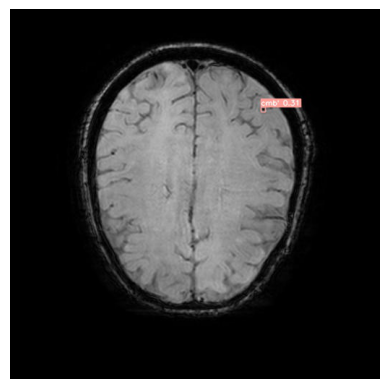

In [30]:

# 加载图像文件
im = plt.imread('D:/dachuang/runs/detect/predict/'+img)
plt.axis('off')
plt.imshow(im)

ruta_a_borrar = 'D:/dachuang/runs/detect/predict'
borrar_carpeta(ruta_a_borrar)


In [12]:
from ultralytics import YOLO
from PIL import Image
import random
import os

# Load the pre-trained model weights
model = YOLO("D:/dachuang/runs/detect/train9/weights/best.pt")

# Specify the path to the images to be predicted
images_path = "D:/dachuang/dataset/jpg/"
img = random.sample(os.listdir(images_path), 1)
img = img[0]
print(img)

# Perform object detection and save the detection results
results = model.predict(source=images_path, save=True)

# Process the detection results for each image
for result in results:
    boxes = result.xyxy
    image_path = result.img_path

    # Check if any objects are detected in the image
    if len(boxes) > 0:
        # Save the image with detected objects
        image = Image.open(image_path)
        image_name = os.path.basename(image_path)
        image_name_without_extension = os.path.splitext(image_name)[0]
        save_path = f"detected_images/{image_name_without_extension}_detected.jpg"
        image.save(save_path)

        # Output information about the detected objects
        print("Detected objects image saved:", save_path)
        for box in boxes:
            class_id = result.names[box[5]]
            cords = [round(x) for x in box[:4]]
            conf = round(box[4], 2)
            print("Object type:", class_id)
            print("Coordinates:", cords)
            print("Probability:", conf)
            print("---")
    else:
        print("No objects detected:", image_path)


slice_2.jpg



image 1/150 D:\dachuang\dataset\jpg\slice_0.jpg: 640x640 (no detections), 194.5ms
image 2/150 D:\dachuang\dataset\jpg\slice_1.jpg: 640x640 (no detections), 83.5ms
image 3/150 D:\dachuang\dataset\jpg\slice_10.jpg: 640x640 (no detections), 84.5ms
image 4/150 D:\dachuang\dataset\jpg\slice_100.jpg: 640x640 1 cmb', 83.0ms
image 5/150 D:\dachuang\dataset\jpg\slice_101.jpg: 640x640 1 cmb', 82.7ms
image 6/150 D:\dachuang\dataset\jpg\slice_102.jpg: 640x640 1 cmb', 84.4ms
image 7/150 D:\dachuang\dataset\jpg\slice_103.jpg: 640x640 (no detections), 83.2ms
image 8/150 D:\dachuang\dataset\jpg\slice_104.jpg: 640x640 (no detections), 84.1ms
image 9/150 D:\dachuang\dataset\jpg\slice_105.jpg: 640x640 (no detections), 83.0ms
image 10/150 D:\dachuang\dataset\jpg\slice_106.jpg: 640x640 (no detections), 84.4ms
image 11/150 D:\dachuang\dataset\jpg\slice_107.jpg: 640x640 (no detections), 83.6ms
image 12/150 D:\dachuang\dataset\jpg\slice_108.jpg: 640x640 (no detections), 84.7ms
image 13/150 D:\dachuang\datase

image 100/150 D:\dachuang\dataset\jpg\slice_53.jpg: 640x640 (no detections), 84.9ms
image 101/150 D:\dachuang\dataset\jpg\slice_54.jpg: 640x640 (no detections), 83.3ms
image 102/150 D:\dachuang\dataset\jpg\slice_55.jpg: 640x640 (no detections), 84.3ms
image 103/150 D:\dachuang\dataset\jpg\slice_56.jpg: 640x640 (no detections), 84.5ms
image 104/150 D:\dachuang\dataset\jpg\slice_57.jpg: 640x640 (no detections), 83.3ms
image 105/150 D:\dachuang\dataset\jpg\slice_58.jpg: 640x640 (no detections), 83.5ms
image 106/150 D:\dachuang\dataset\jpg\slice_59.jpg: 640x640 (no detections), 83.4ms
image 107/150 D:\dachuang\dataset\jpg\slice_6.jpg: 640x640 (no detections), 83.0ms
image 108/150 D:\dachuang\dataset\jpg\slice_60.jpg: 640x640 (no detections), 83.2ms
image 109/150 D:\dachuang\dataset\jpg\slice_61.jpg: 640x640 (no detections), 83.0ms
image 110/150 D:\dachuang\dataset\jpg\slice_62.jpg: 640x640 (no detections), 83.3ms
image 111/150 D:\dachuang\dataset\jpg\slice_63.jpg: 640x640 (no detections), 

AttributeError: 'Results' object has no attribute 'xyxy'. See valid attributes below.

    A class for storing and manipulating inference results.

    Args:
        orig_img (numpy.ndarray): The original image as a numpy array.
        path (str): The path to the image file.
        names (dict): A dictionary of class names.
        boxes (torch.tensor, optional): A 2D tensor of bounding box coordinates for each detection.
        masks (torch.tensor, optional): A 3D tensor of detection masks, where each mask is a binary image.
        probs (torch.tensor, optional): A 1D tensor of probabilities of each class for classification task.
        keypoints (List[List[float]], optional): A list of detected keypoints for each object.

    Attributes:
        orig_img (numpy.ndarray): The original image as a numpy array.
        orig_shape (tuple): The original image shape in (height, width) format.
        boxes (Boxes, optional): A Boxes object containing the detection bounding boxes.
        masks (Masks, optional): A Masks object containing the detection masks.
        probs (Probs, optional): A Probs object containing probabilities of each class for classification task.
        names (dict): A dictionary of class names.
        path (str): The path to the image file.
        keypoints (Keypoints, optional): A Keypoints object containing detected keypoints for each object.
        speed (dict): A dictionary of preprocess, inference and postprocess speeds in milliseconds per image.
        _keys (tuple): A tuple of attribute names for non-empty attributes.
    